In [28]:
from ct.fs import *
%matplotlib inline
from ct.alfafactory import *
from croqr.common.utils import load_df

In [11]:
df0 = load_df('df0')
df0.columns = ['o','c','h','l']
df0['v'] = df0['h'].astype(int)
df0 = df0.resample('15Min').last().ffill()
display(df0.head(5))

,o,c,h,l,v
datetime,,,,,
2016-06-14 03:00:00,694.85,694.895,694.85,694.86,694
2016-06-14 03:15:00,695.62,695.625,695.44,695.625,695
2016-06-14 03:30:00,693.67,693.68,693.355,693.365,693
2016-06-14 03:45:00,693.615,693.645,693.61,693.645,693
2016-06-14 04:00:00,694.105,694.105,693.47,693.47,693


In [45]:
def vbtstrat(df0,df1,lag=20,nstdl=2,nstdh=2,methodma='ma',methodstd='ma',verbose=0,plot=False):
    spread_bps = (df0.c-df1.c)/df1.c
    bb=addbb(df=DF({'spread':spread_bps}), lags=lag,methodma=methodma,methodstd=methodstd,nstdh=nstdh,nstdl=nstdl,dropna=False)
    bb.iplot()
    entries_dirty = bb['spread'] < bb['bbl.spread']
    exits_dirty = bb['spread'] > bb['bbh.spread']
    #entries[entries==True]
    entries,exits = pd.Series.vbt.signals.clean(entries_dirty,exits_dirty, entry_first=True, broadcast_kwargs=dict(columns_from='keep'))
    
    
    if plot:
        fig = vbt.make_subplots(specs=[[{"secondary_y": True}]])
        
        
#         fig = vbt.make_subplots(
#         rows=5, cols=1, shared_xaxes=True, 
#         row_heights=[*[0.5 / 3] * len(symbols), 0.25, 0.25], vertical_spacing=0.05,
#         subplot_titles=(*symbols, '%B', 'Bandwidth'))
        
        
        fig = spread_bps.vbt.plot(trace_kwargs=dict(name='df0.c'), fig=fig)
        #fig = df1['c'].vbt.plot(trace_kwargs=dict(name='df1.c'), fig=fig)
        fig = entries.vbt.signals.plot_as_entry_markers(spread_bps, fig=fig)
        fig = exits.vbt.signals.plot_as_exit_markers(spread_bps, fig=fig)
        fig.update_layout(template='vbt_dark', showlegend=False, width=1600, height=300)
        fig.show()
    
    # #ts exits
    # # Execute at the next bar
    # vbt_entries= pd.Series.vbt.signals.empty_like(dfbtc1['c'])
    # vbt_entries.loc[dfliq1[dfliq1['v'].shift(1)>liqlimit].index]=True
    # ts_exits = vbt.OHLCSTEX.run(vbt_entries,df0['o'],df0['h'],dfbtc1['l'],dfbtc1['c'],ts_stop=list(stops),wait=1,stop_type=None, hit_price=None).exits
    # vbt_entries, vbt_exits = pd.DataFrame.vbt.signals.clean(vbt_entries, ts_exits)
    # portf = vbt.Portfolio.from_signals(dfbtc1['o'], vbt_entries, ts_exits, price=dfbtc1['o'])#.vbt.fshift(1))
    #percentage order size
    symbol_cols = pd.Index([0, 1], name='symbol')
    ordersize = pd.DataFrame(index=entries.index, columns=symbol_cols)
    ordersize[0] = np.nan
    ordersize[1] = np.nan
    ordersize.loc[exits, 0] = -1
    ordersize.loc[entries, 0] = 1
    ordersize.loc[exits, 1] = 1
    ordersize.loc[entries, 1] = -1

    #shoft ordersize
    ordersize = ordersize.vbt.fshift(1)

    portf=vbt.Portfolio.from_orders(
            close=pd.concat((df0['c'], df1['c']), axis=1, keys=symbol_cols),  # current close as reference price
            size=ordersize,  
            price=pd.concat((df0['o'], df1['o']), axis=1, keys=symbol_cols),  # current open as execution price
            size_type='targetpercent', 
            val_price=pd.concat((df0['c'], df1['c']), axis=1, keys=symbol_cols),#.vbt.fshift(1),  # previous close as group valuation price
            init_cash=10000,
            fees=0.0006,
            cash_sharing=True,  # share capital between assets in the same group
            group_by=True,  # all columns belong to the same group
            call_seq='auto',  # sell before buying
            freq='d'  # index frequency for annualization
        )

    if verbose:
        entries.astype('float').plot()
        exits.astype('float').plot()
        ordersize.dropna().plot(marker='x')
        portf.orders.records_readable
        portf.trades.records_readable
        portf.stats()
        
        
    #for nstdl in np.linspace(1,2.2,20):
    for nstdh in np.linspace(1,2.2,20):
        vbstratres=vbtstrat(df0,df1,lag=100,nstdl=nstdl,nstdh=nstdh)
        dff[nstdl,nstdh]=vbstratres['portf'].returns()
        resSRtotal.append({'nstdl':nstdl,'nstdh':nstdh,'SR':vbstratres['portf'].sharpe_ratio()})
        resNTtotal.append({'nstdl':nstdl,'nstdh':nstdh,'NT':(vbstratres['entries'].astype(float).sum()+vbstratres['exits'].astype(float).sum())/((dff.index[-1]-dff.index[0])/pd.Timedelta('4.33w'))
    })    
        
        
        
    return {'portf':portf,'entries':entries,'exits':exits,'entries_dirty':entries_dirty,'exits_dirty':exits_dirty,'SR':portf.sharpe_ratio(),'ind':bb}
#vbtstrat(df0,df1,spreadL=-600,spreadH=-100,verbose=0)

In [ ]:
dff=pd.DataFrame(columns=pd.MultiIndex.from_tuples([(np.nan,np.nan)],names=['nstdl','nstdh']),index=df0['c'].index)
dff.head(2)

resSRtotal=[]
resNTtotal=[]

for nstdl in np.linspace(1,5,3):
    for nstdh in np.linspace(1,5,3):
        print(nstdl, nstdh)
        vbstratres=vbtstrat(df0,df1,lag=100,nstdl=nstdl,nstdh=nstdh)
        dff[nstdl,nstdh]=vbstratres['portf'].returns()
        resSRtotal.append({'nstdl':nstdl,'nstdh':nstdh,'SR':vbstratres['portf'].sharpe_ratio()})
        resNTtotal.append({'nstdl':nstdl,'nstdh':nstdh,'NT':(vbstratres['entries'].astype(float).sum()+vbstratres['exits'].astype(float).sum())/((dff.index[-1]-dff.index[0])/pd.Timedelta('4.33w'))
})
        

dff.drop(np.nan, axis=1, level=1,inplace=True)
dff.head()        
#dff.plot()
DF(resSRtotal).pivot('nstdl','nstdh').vbt.heatmap()

DF(resNTtotal).pivot('nstdl','nstdh').vbt.heatmap()# if very few trades, do not consider these params, exclude them form PBO calculation


DF(resSRtotal).pivot('nstdl','nstdh')

#Entirely possible that all the N strategy configs have high but similar Sharpe ratios. Therefore, PBO may appear high, however, 'overfitting' here is among many 'skilful' strategies.

pypbo.pbo(dff, S=8, metric_func=lambda x: perf.sharpe_iid(x), threshold=1, n_jobs=4,plot=True, verbose=False, hist=False)

In [17]:
df1 = df0.copy()

In [ ]:
df1.addbb(lags=1)

In [31]:
spread_bps = (df0.c-df1.c)/df1.c

<AxesSubplot:xlabel='datetime'>

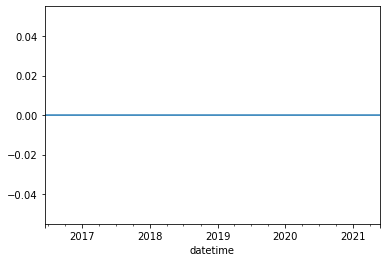

In [33]:
spread_bps.plot()

In [42]:
lag = 
DF({'spread':spread_bps}).pipe(addbb(lags=lag,methodma=methodma,methodstd=methodstd,nstdh=nstdh,nstdl=nstdl,dropna=False))

NameError: name 'lag' is not defined

In [53]:
lag=20
nstdl=2
nstdh=2
methodma='ma'
methodstd='ma'
verbose=0
plot=False
bb=addbb(df=DF({'spread':spread_bps}), lags=lag,methodma=methodma,methodstd=methodstd,nstdh=nstdh,nstdl=nstdl,dropna=False)

entries_dirty = bb['spread'] < bb['bbl.spread']
exits_dirty = bb['spread'] > bb['bbh.spread']
#entries[entries==True]
entries,exits = pd.Series.vbt.signals.clean(entries_dirty,exits_dirty, entry_first=True, broadcast_kwargs=dict(columns_from='keep'))

In [57]:
pd.Series.vbt??

Init signature: pd.Series.vbt(obj: pandas.core.series.Series, **kwargs) -> None
Source:        
class Vbt_SRAccessor(DirNamesMixin, GenericSRAccessor):
    """The main vectorbt accessor for `pd.Series`."""

    def __init__(self, obj: tp.Series, **kwargs) -> None:
        self._obj = obj

        DirNamesMixin.__init__(self)
        GenericSRAccessor.__init__(self, obj, **kwargs)
File:           c:\users\wang\anaconda3\lib\site-packages\vectorbt\root_accessors.py
Type:           MetaGenericAccessor
Subclasses:     
